In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import re
import random
from sklearn import preprocessing
import gc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

from summary_fn import *

# Load data

In [2]:
# Import data 
data = pd.read_csv('features_train_data.csv')

In [ ]:
# Display the transpose of the rows to visualize all columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [ ]:
display_all(data.head().T)

### Pre processing for RandomForest
We will convert few columns to percentage of total songs per user to normalize the data and improve the feature

In [3]:
# Normalize data into percentage for following columns
hnorm_cols = ['msno_genre_count', 'source_system_tab_user_lev_c', 'source_screen_name_user_lev_c',
             'source_type_user_lev_c','composer_user_lev_c', 'lyricist_user_lev_c', 'artist_name_user_lev_c' ]

for i in hnorm_cols:
    data[i] = data[i]/data['msno_appear_count']

In [4]:
data.drop(columns='lyricist_count_y', inplace= True)

#### Imputaion
Since we have a lot of data missing for few columns and RandomForest is not succeptible to NA values, we will replace continuous columns with -1 and categorical varaibles with 'NA' to treat them as features and levels. 

In [5]:
# Imputing continuous columns
na_continuous_col = ['msno_genre_count', 'source_system_tab_user_lev_c', 'source_screen_name_user_lev_c', 
                    'source_type_user_lev_c', 'artist_name_user_lev_c', 'composer_user_lev_c', 
                    'lyricist_user_lev_c']
for col in na_continuous_col:
    data[col] = data[col].fillna(-1)    

In [6]:
# Imputing categorical columns
data = data.fillna('Not')

In [7]:
# Label encoding for the categorical varaibles 
from sklearn import preprocessing
def encoder(x_train):
    le = preprocessing.LabelEncoder()
    for column_name in x_train.columns:
            if x_train[column_name].dtype.name in ['category','object']:
                x_train[column_name] = le.fit_transform(x_train[column_name].astype(str))

# Encode the data
encoder(data)

# Model Fitting

In [8]:
# Features and target varaibles
X = data.drop(columns='target',axis=1)
y = data['target']

# Train and test split
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train and validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=1)

In [9]:
del data
gc.collect()

14

In [10]:
# Sampled train data 
random.seed(130)
idx = random.sample(range(0,X_train.shape[0]), 100000)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

In [11]:
# Model fitting
rf = RandomForestClassifier(n_estimators=100, oob_score=False, random_state=1,n_jobs=-1)
rf.fit(X_train_sampled, y_train_sampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [12]:
predicted = rf.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score on validation: {accuracy:.3}')

Mean accuracy score on validation: 0.665


In [13]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score on test: {accuracy:.3}')

Mean accuracy score on test: 0.665


### Feature selection

In [14]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(rf, X_train_sampled ); fi[:10]

,cols,imp
48,song_play_counts,0.050303
58,artist_name_user_lev_c,0.035809
50,msno_appear_count,0.033347
14,msno_genre_count,0.032334
56,source_type_user_lev_c,0.031731
5,song_length,0.031193
54,source_screen_name_user_lev_c,0.030867
1,song_id,0.030862
0,msno,0.030452
52,source_system_tab_user_lev_c,0.030227


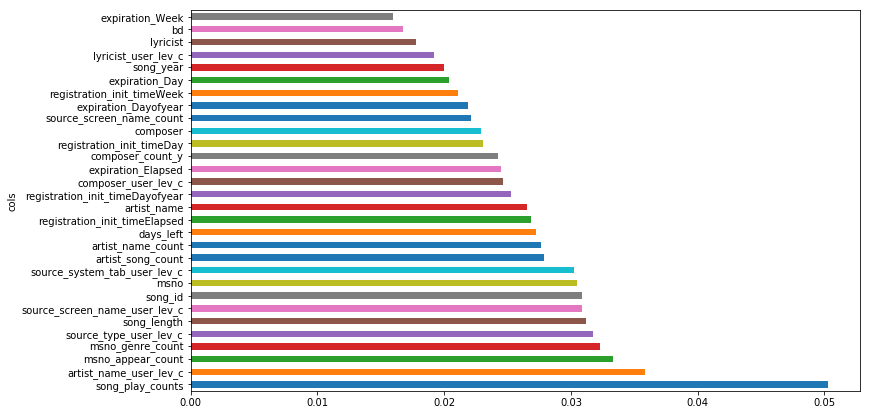

In [15]:
def plot_fi(fi):return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [16]:
to_keep = fi[fi.imp>0.015].cols; len(to_keep)

31

In [17]:
X_train_sampled = X_train_sampled[to_keep]
X_val = X_val[to_keep]
X_test = X_test[to_keep]
X_train = X_train[to_keep]

In [ ]:
# Pipeline and grid search
pipe_dt = Pipeline([('clf', RandomForestClassifier(n_jobs=-1))]) # Estimator: ML algorithm

grid_params = dict(clf__n_estimators = [50,100,150,200],
                  clf__max_features = ['sqrt', 'log2'],
                  clf__min_samples_split = [2,10,20])

gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled)
f"{gs.score(X_test, y_test):.4f}"

In [ ]:
# Best algorithm with best hyperparameters (need to fit it to find specific model parameters)
print(gs.best_estimator_)

# Best model with specific model parameters
gs.best_estimator_.get_params()['clf']

In [ ]:
gs.best_estimator_.get_params()['clf']

In [18]:
m = RandomForestClassifier(n_estimators=100, n_jobs=-1,oob_score=False,max_features='sqrt', min_samples_split= 10)
m.fit(X_train, y_train)
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')

Mean accuracy score validation: 0.748


In [19]:
# Test accuracy
predicted = m.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score test: {accuracy:.3}')

Mean accuracy score test: 0.748


# Evaluation Metric

In [20]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.75054131 0.74622126]
recall: [0.73812454 0.7583798 ]
fscore: [0.74428114 0.7522514 ]
support: [732119 743365]


Confusion matrix, without normalization
[[540395 191724]
 [179612 563753]]
Normalized confusion matrix
[[0.74 0.26]
 [0.24 0.76]]


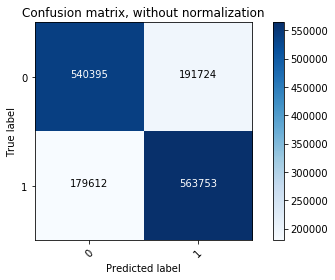

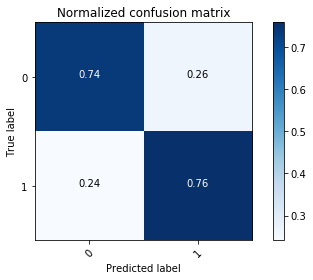

In [21]:
import itertools
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
